In [1]:
import numpy as np
import os
from torch.utils.data import Dataset
import librosa
import torch
import matplotlib.pyplot as plt
from torch import nn
import tqdm
import torchvision
from sklearn.metrics import roc_curve


from torchvision.models import resnet34

device =  'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Using {device}")

Using cuda


In [7]:
def pad_random(x: np.ndarray, max_len: int = 64000):
    x_len = x.shape[0]
    if x_len > max_len:
        stt = np.random.randint(x_len - max_len)
        return x[stt:stt + max_len]

    num_repeats = int(max_len / x_len) + 1
    padded_x = np.tile(x, (num_repeats))
    return pad_random(padded_x, max_len)

class SVDD2024(Dataset):
    """
    Dataset class for the SVDD 2024 dataset.
    """
    def __init__(self, base_dir, partition="train", max_len=64000):
        assert partition in ["train", "dev", "test"], "Invalid partition. Must be one of ['train', 'dev', 'test']"
        self.base_dir = base_dir
        self.partition = partition
        self.base_dir = os.path.join(base_dir, partition + "_set")
        self.max_len = max_len

        self.transforms = torchvision.transforms.Compose([torchvision.transforms.Resize((224,224))])
        
        try:
            with open(os.path.join(base_dir, f"{partition}.txt"), "r") as f:
                self.file_list = f.readlines()
        except FileNotFoundError:
            if partition == "test":
                self.file_list = []
                # get all *.flac files in the test_set directory
                for root, _, files in os.walk(self.base_dir):
                    for file in files:
                        if file.endswith(".flac"):
                            self.file_list.append(file)
            else:
                raise FileNotFoundError(f"File {partition}.txt not found in {base_dir}")


            
    
    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):            
        if self.partition == "test":
            file_name = self.file_list[index].strip()
            label = 0 # dummy label. Not used for test set.
        else:
            file = self.file_list[index]
            file_name = file.split(" ")[2].strip()
            bonafide_or_spoof = file.split(" ")[-1].strip()
            label = 1 if bonafide_or_spoof == "bonafide" else 0
        try:
            x, _ = librosa.load(os.path.join(self.base_dir, file_name + ".flac"), sr=16000, mono=True)
            x = pad_random(x, self.max_len) # x = pad_random (audio,64000)
            x = librosa.util.normalize(x)
            x = librosa.feature.chroma_cqt(y=x,sr=16000,hop_length=160)
            #x = np.abs(librosa.stft(x))
            x= librosa.amplitude_to_db(x,ref=np.max)
            # file_name is used for generating the score file for submission
            #return self.transforms(torch.unsqueeze(torch.from_numpy(x),dim=0)), label, file_name
            return torch.unsqueeze(torch.from_numpy(x),dim=0), label, file_name

        except Exception as e:
            print(f"Error loading {file_name}: {e}")
            return None

In [8]:
train_ds=SVDD2024('./temp/ds/',partition='train')
test_ds=SVDD2024('./temp/ds/',partition='dev')

In [9]:
print(len(train_ds))
print(len(test_ds))

84404
43625


In [10]:
train_loader=torch.utils.data.DataLoader(train_ds,batch_size=16)
test_loader=torch.utils.data.DataLoader(test_ds,batch_size=16)

torch.Size([1, 12, 401])


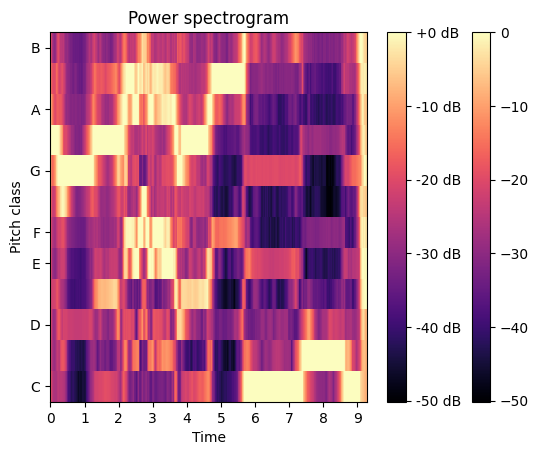

In [11]:
print(train_ds[0][0].shape)
#img = librosa.display.specshow(,y_axis='log', x_axis='time', ax=ax)
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True)
img = librosa.display.specshow(np.asanyarray(train_ds[0][0][0]), y_axis='chroma', x_axis='time', ax=ax)
#ax[1].set(title='chroma_cqt')
fig.colorbar(img, ax=ax)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")              

In [12]:
model=resnet34()

In [13]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
model.conv1=nn.Conv2d(1,64,kernel_size=(7,7),stride=(2,2),padding=(3,3),bias=False)
model.fc=nn.Linear(512,1)

In [15]:
with torch.inference_mode():
    print(model(torch.rand((1,1,12,126))))

tensor([[0.5714]])


In [16]:
def accuracy_fn(logits,true):
    return torch.eq(torch.argmax(torch.softmax(logits,dim=1),dim=1).squeeze(),true).sum().item()/len(logits)

In [17]:
dt=next(iter(train_loader))
loss_fn=nn.BCEWithLogitsLoss()

with torch.inference_mode():
    x=dt[0]
    y=dt[1]
    logits=model(x)
    print(torch.sigmoid(logits).squeeze())
    print(y.type(torch.float32))
    print(loss_fn(logits.squeeze(),y.type(torch.float32)))

tensor([0.6570, 0.6116, 0.5927, 0.6486, 0.6168, 0.5699, 0.5895, 0.4854, 0.5364,
        0.5863, 0.6347, 0.6276, 0.5373, 0.5864, 0.5995, 0.5849])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor(0.5278)


In [39]:
def train_model(model, epochs):
    model = model.to(device)
    optimizer = torch.optim.Adam(params=model.parameters())
    loss_fn = nn.BCEWithLogitsLoss()

    for i in tqdm.notebook.tqdm(range(epochs)):
        train_preds = torch.tensor([], device=device)
        val_preds = torch.tensor([], device=device)
        train_actual = torch.tensor([], device=device)
        val_actual = torch.tensor([], device=device)
        
        print("\nTraining:")
        model.train()
        
        temp_train_loss = []
        temp_val_loss = []
    
        net_train_loss = 0
        net_val_loss = 0
        
        with tqdm.notebook.tqdm(total=len(train_loader)) as pbar:
            for x, y, _ in train_loader:
                x = x.to(device)
                y = y.to(device).type(torch.float32)

                logits = model(x)
        
                optimizer.zero_grad()
                loss = loss_fn(logits.squeeze(), y)
                
                preds = torch.sigmoid(logits).detach().squeeze()
                train_preds = torch.cat((train_preds, preds))
                train_actual = torch.cat((train_actual, y))
                
                temp_train_loss.append(loss.item())
                
                loss.backward()
                optimizer.step()
                
                pbar.update(1)
            pbar.close()
        
        net_train_loss = sum(temp_train_loss) / len(temp_train_loss)
    
        print("Testing:")
        model.eval()
    
        with tqdm.notebook.tqdm(total=len(test_loader)) as pbar2:
            for x, y, _ in test_loader:
                x = x.to(device)
                y = y.to(device).type(torch.float32)
                
                with torch.inference_mode():
                    logits = model(x)
                    loss = loss_fn(logits.squeeze(), y.type(torch.float32))
                    
                    preds = torch.sigmoid(logits).detach().squeeze()
                    val_preds = torch.cat((val_preds, preds))
                    val_actual = torch.cat((val_actual, y))
                    
                    temp_val_loss.append(loss.item())
    
                    pbar2.update(1)
            pbar2.close()
    
        net_val_loss = sum(temp_val_loss) / len(temp_val_loss)
        
        fpr, tpr, thresholds = roc_curve(val_actual.cpu().numpy(), val_preds.cpu().numpy())
        fnr = 1 - tpr
        eer_threshold = thresholds[np.nanargmin(np.absolute((fnr - fpr)))]
        eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
        
        print(f"\nEpoch {i+1}:\nTrain Loss: {net_train_loss}\nVal Loss: {net_val_loss}\nEER: {eer}\nEER Threshold: {eer_threshold}\n")


In [40]:
train_model(model,100)

  0%|          | 0/100 [00:00<?, ?it/s]


Training:


  0%|          | 0/5276 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(),'epoch-100.pt')